<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/nifty_%25_above_50_dma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yfinance --q

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
nifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()
# Bank Nifty Stocks
bank_nifty_stocks = tickers

def calculate_percentage_above_moving_average(stock_list,periods,start_date):
    data = yf.download(stock_list, start=start_date)
    data = data['Adj Close']

    # Calculate the moving average using ewm with min_periods set to 50
    ma = data.ewm(span=periods, min_periods=periods).mean()

    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / len(stock_list)) * 100

    return percentage

# Calculate the percentage of stocks above their 200 DMA for each day
percentage_above_dma = calculate_percentage_above_moving_average(bank_nifty_stocks,200,'2020-01-01')
percentage_20_dma=calculate_percentage_above_moving_average(bank_nifty_stocks,50,'2020-01-01')
# Download the Bank Nifty index data
bank_nifty = yf.download('^NSEI', start='2020-01-01')

# Reindex Bank Nifty index data to match percentage_above_dma
aligned_bank_nifty_close = bank_nifty['Adj Close'].reindex(percentage_above_dma.index)




[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed


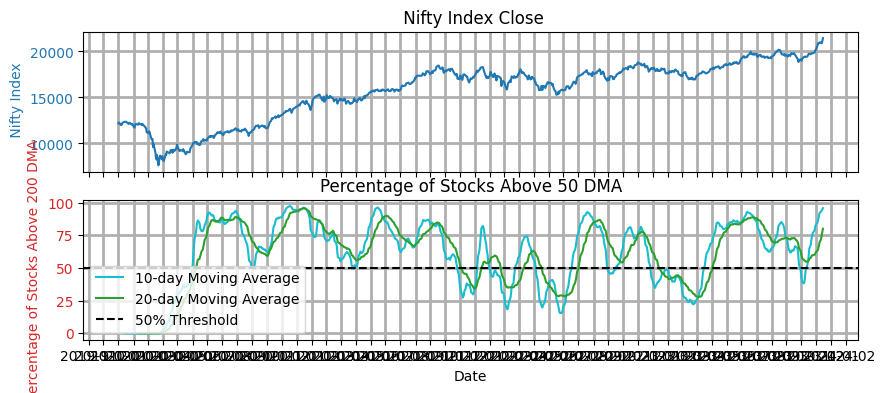

In [3]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_bank_nifty_close.index, aligned_bank_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
#ax2.plot(percentage_above_dma.index, percentage_above_dma, color='tab:red', label='Percentage Above 200 DMA')
ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=10).mean(), color='tab:cyan', label='10-day Moving Average')
ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=30).mean(), color='tab:green', label='20-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=50, color='black', linestyle='dashed', label='50% Threshold')
ax2.legend()

yloc = YearLocator()
mloc = MonthLocator()
ax1.xaxis.set_major_locator(mloc)
ax2.xaxis.set_major_locator(mloc)
#ax[2].xaxis.set_major_locator(mloc)
ax1.grid(linewidth =2)
ax2.grid(linewidth =2)
#ax[2].grid(linewidth =2)


plt.show()


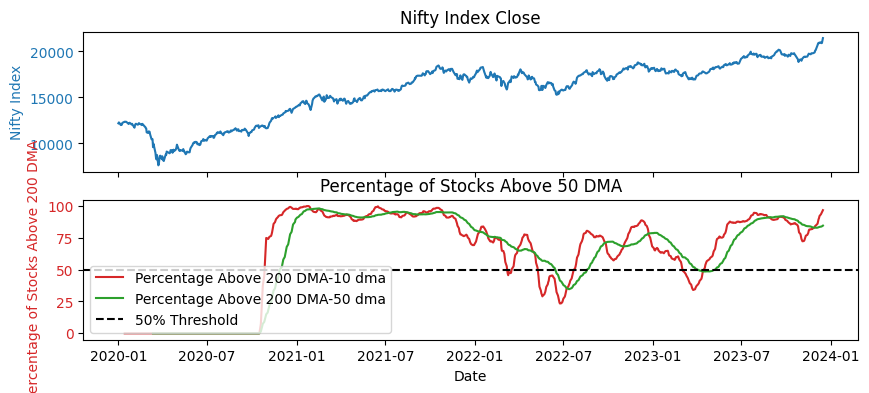

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel('Nifty Index', color='tab:blue')
ax1.plot(aligned_bank_nifty_close.index, aligned_bank_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
ax2.plot(percentage_above_dma.index, percentage_above_dma.rolling(window=10).mean(), color='tab:red', label='Percentage Above 200 DMA-10 dma')
ax2.plot(percentage_above_dma.index, percentage_above_dma.rolling(window=50).mean(), color='tab:green', label='Percentage Above 200 DMA-50 dma')

#ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=10).mean(), color='tab:cyan', label='10-day Moving Average')
#ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=30).mean(), color='tab:green', label='20-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=50, color='black', linestyle='dashed', label='50% Threshold')
ax2.legend()



plt.show()


In [5]:
result = percentage_above_dma.rolling(window=10).mean() - percentage_above_dma.rolling(window=30).mean()
result1=percentage_above_dma.rolling(window=10).mean() - percentage_above_dma.rolling(window=50).mean()

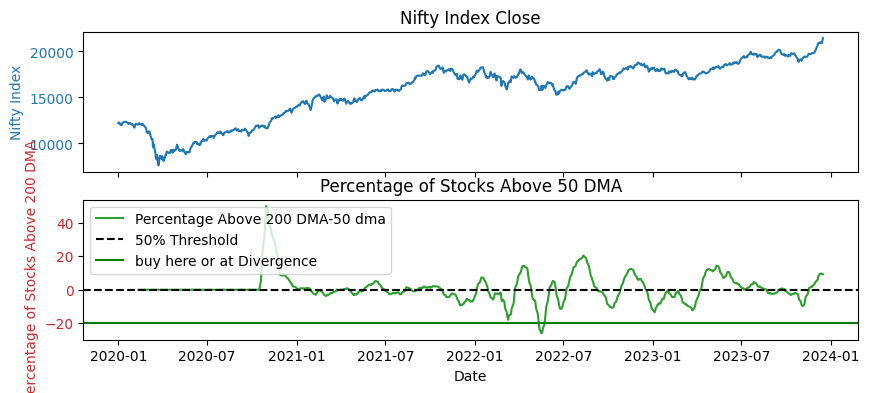

In [6]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel('Nifty Index', color='tab:blue')
ax1.plot(aligned_bank_nifty_close.index, aligned_bank_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
ax2.plot(percentage_above_dma.index,result, color='tab:green', label='Percentage Above 200 DMA-50 dma')

#ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=10).mean(), color='tab:cyan', label='10-day Moving Average')
#ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=30).mean(), color='tab:green', label='20-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=0, color='black', linestyle='dashed', label='50% Threshold')
ax2.axhline(y=-20, color='green', label='buy here or at Divergence')
ax2.legend()



plt.show()


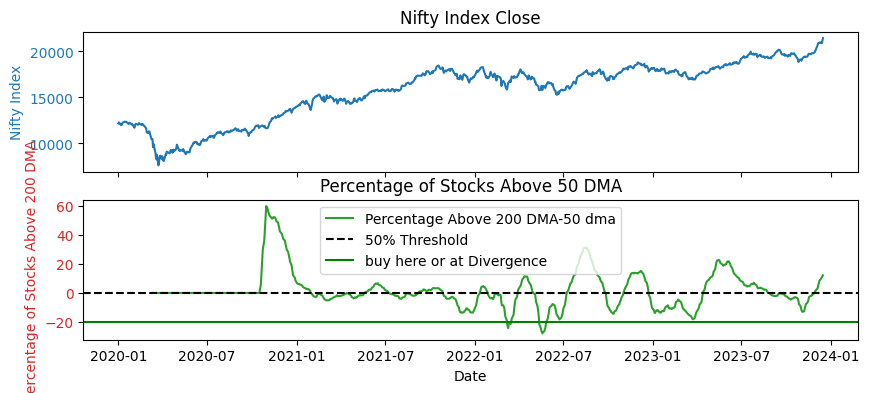

In [7]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel('Nifty Index', color='tab:blue')
ax1.plot(aligned_bank_nifty_close.index, aligned_bank_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
ax2.plot(percentage_above_dma.index,result1, color='tab:green', label='Percentage Above 200 DMA-50 dma')

#ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=10).mean(), color='tab:cyan', label='10-day Moving Average')
#ax2.plot(percentage_20_dma.index, percentage_20_dma.rolling(window=30).mean(), color='tab:green', label='20-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=0, color='black', linestyle='dashed', label='50% Threshold')
ax2.axhline(y=-20, color='green', label='buy here or at Divergence')
ax2.legend()



plt.show()
